# EMPCA vs Linear Autoencoder Equivalence (Improved)

This notebook compares EMPCA to a **complex linear autoencoder in whitened frequency space**,
which is the mathematically consistent counterpart of your current EMPCA representation.

Why the previous notebook looked off:
- It compared complex EMPCA against a real-feature AE directly.
- A rank-`k` complex subspace is not generally identical to a rank-`k` real subspace.
- That mismatch can produce small but statistically detectable gaps.

Primary test here:
1. Whiten frequency-domain data with PSD weights.
2. Train EMPCA (`k`) on whitened complex data.
3. Train complex tied linear AE (`k`) in the same space.
4. Compare subspace angles and weighted residuals.


In [1]:
import sys
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

sys.path.append("../../")
from reusable.empca_equivalence_utils import (
    baseline_correct,
    build_of_one_sided_weights,
    fit_empca_no_smoothing,
    project_gls,
    weighted_residual_energy,
    rfft_to_weighted_real_features,
)

plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["font.size"] = 12


In [2]:
# Same dataset and selection criteria as strict notebook
TRACES_PATH = "../../reusable/k_alpha/k_alpha_traces.h5"
PSD_PATH = "/ceph/dwong/delight/noise_psd_xray.npy"

PRETRIGGER = 2000
N_REAL_LIMIT = None

# Model controls
K = 1
N_ITER_EMPCA = 80
EMPCA_PATIENCE = 40
AE_EPOCHS = 40
AE_SEED = 0

with h5py.File(TRACES_PATH, "r") as f:
    X_all = f["traces"][:].astype(np.float64)

if N_REAL_LIMIT is not None:
    X_all = X_all[:N_REAL_LIMIT]

X_all = baseline_correct(X_all, pretrigger=PRETRIGGER)

psd_arr = np.load(PSD_PATH)
if psd_arr.ndim == 2 and psd_arr.shape[0] == 2:
    J_psd = psd_arr[1]
else:
    J_psd = psd_arr
J_psd = J_psd.astype(np.float64)

n_train = X_all.shape[0] // 2
X_train_t = X_all[:n_train]
X_test_t = X_all[n_train:]

X_train_f = np.fft.rfft(X_train_t, axis=1)
X_test_f = np.fft.rfft(X_test_t, axis=1)

w_of = build_of_one_sided_weights(J_psd, X_all.shape[1])
sqrt_w = np.sqrt(w_of)

# Whitened complex representation used for both methods
X_train_w = (X_train_f * sqrt_w[None, :]).astype(np.complex64)
X_test_w = (X_test_f * sqrt_w[None, :]).astype(np.complex64)

print(f"traces total/train/test: {X_all.shape[0]} / {X_train_t.shape[0]} / {X_test_t.shape[0]}")
print(f"trace length: {X_all.shape[1]}, rfft bins: {X_train_f.shape[1]}")
print(f"K={K}, EMPCA iters={N_ITER_EMPCA}, AE epochs={AE_EPOCHS}")
print("Tip: validate K=1 first, then increase K.")


traces total/train/test: 4358 / 2179 / 2179
trace length: 32768, rfft bins: 16385
K=1, EMPCA iters=80, AE epochs=40
Tip: validate K=1 first, then increase K.


## Complex Linear AE Structure

In whitened complex space, use tied weights:

\[
z = XW, \qquad \hat X = zW^H = XWW^H
\]

with orthonormal columns \(W^H W = I\). This is a rank-`k` orthogonal projector.


## Rigor Checklist (For Equivalence Claims)

Use this checklist before claiming EMPCA \(\Leftrightarrow\) linear AE equivalence:

- [ ] **Same data split/preprocessing** for both methods (baseline correction, train/test partition).
- [ ] **Same noise model** used in both methods (same PSD and whitening operator).
- [ ] **Same optimization target** (projection/reconstruction in whitened complex space).
- [ ] **Same rank `k`** for EMPCA and AE.
- [ ] **Compare to exact baseline**: include SVD-based exact complex linear AE (not only iterative training).
- [ ] **Subspace agreement**: report principal-angle cosine(s) and angle(s).
- [ ] **Reconstruction agreement**: report weighted residual distributions and KS statistic/p-value.
- [ ] **Effect size**: report relative mean residual difference (not p-value alone).
- [ ] **Numerical gauge handling**: account for sign/phase/rotation ambiguity when comparing bases.
- [ ] **Scope statement**: claim equivalence only for the linear Gaussian weighted setting; do not overgeneralize to nonlinear AE.

Recommended interpretation thresholds (practical):
- principal-angle cosine near 1,
- residual KS statistic near 0 with large p-value,
- relative mean residual difference close to 0.


In [3]:
def orthonormalize_columns_complex(W):
    Q, _ = np.linalg.qr(W)
    return Q


def train_complex_linear_ae_subspace_iteration(X, k, epochs=40, seed=0):
    rng = np.random.default_rng(seed)
    d = X.shape[1]
    W = rng.normal(size=(d, k)) + 1j * rng.normal(size=(d, k))
    W = W.astype(np.complex64)
    W = orthonormalize_columns_complex(W)

    losses = []
    for _ in range(epochs):
        # Subspace iteration for top-k right singular vectors
        W = orthonormalize_columns_complex(X.conj().T @ (X @ W))
        Xhat = (X @ W) @ W.conj().T
        loss = np.mean(np.sum(np.abs(X - Xhat) ** 2, axis=1))
        losses.append(float(loss))

    return W, np.array(losses, dtype=np.float64)


def principal_angle_cosines_complex(Q1, Q2):
    s = np.linalg.svd(Q1.conj().T @ Q2, compute_uv=False)
    return np.clip(np.real(s), 0.0, 1.0)


In [4]:
# 1) EMPCA on whitened complex data
w_unif = np.ones(X_train_w.shape[1], dtype=np.float64)
U_emp, _, chi2_emp = fit_empca_no_smoothing(
    X_train_w,
    w_unif,
    n_comp=K,
    n_iter=N_ITER_EMPCA,
    patience=EMPCA_PATIENCE,
    mode="fast",
)

C_test_emp = project_gls(X_test_w, U_emp, w_unif, return_complex=True)
Xhat_test_emp = C_test_emp @ U_emp
resid_emp = weighted_residual_energy(X_test_w, U_emp, C_test_emp, w_unif)

print(f"EMPCA basis shape: {U_emp.shape}")
print(f"EMPCA chi2 iters: {chi2_emp.shape[0]}, final={chi2_emp[-1]:.6e}")


EMPCA basis shape: (1, 16385)
EMPCA chi2 iters: 42, final=2.118388e+15


In [5]:
# 2) Complex linear AE (iterative) and exact SVD baseline
W_iter, ae_losses = train_complex_linear_ae_subspace_iteration(
    X_train_w,
    k=K,
    epochs=AE_EPOCHS,
    seed=AE_SEED,
)

# Exact closed-form linear AE / complex PCA solution
_, _, Vh = np.linalg.svd(X_train_w, full_matrices=False)
W_exact = Vh[:K].conj().T

Xhat_test_iter = (X_test_w @ W_iter) @ W_iter.conj().T
resid_iter = np.sum(np.abs(X_test_w - Xhat_test_iter) ** 2, axis=1)

Xhat_test_exact = (X_test_w @ W_exact) @ W_exact.conj().T
resid_exact = np.sum(np.abs(X_test_w - Xhat_test_exact) ** 2, axis=1)

print(f"AE iterative decoder shape: {W_iter.shape}")
print(f"AE exact decoder shape: {W_exact.shape}")
print(f"AE final train loss: {ae_losses[-1]:.6e}")


AE iterative decoder shape: (16385, 1)
AE exact decoder shape: (16385, 1)
AE final train loss: 2.118388e+15


Principal-angle cosines (EMPCA vs exact complex AE): [1.]
Principal angles (deg): [0.004635]
Residual KS statistic=0.000918, p=1
Mean test reconstruction gap: 2.054441e+06
Residual means (EMPCA, exact-AE): 2.122095e+15, 2.122095e+15
Relative mean residual difference (exact-AE vs EMPCA): -4.922201e-09


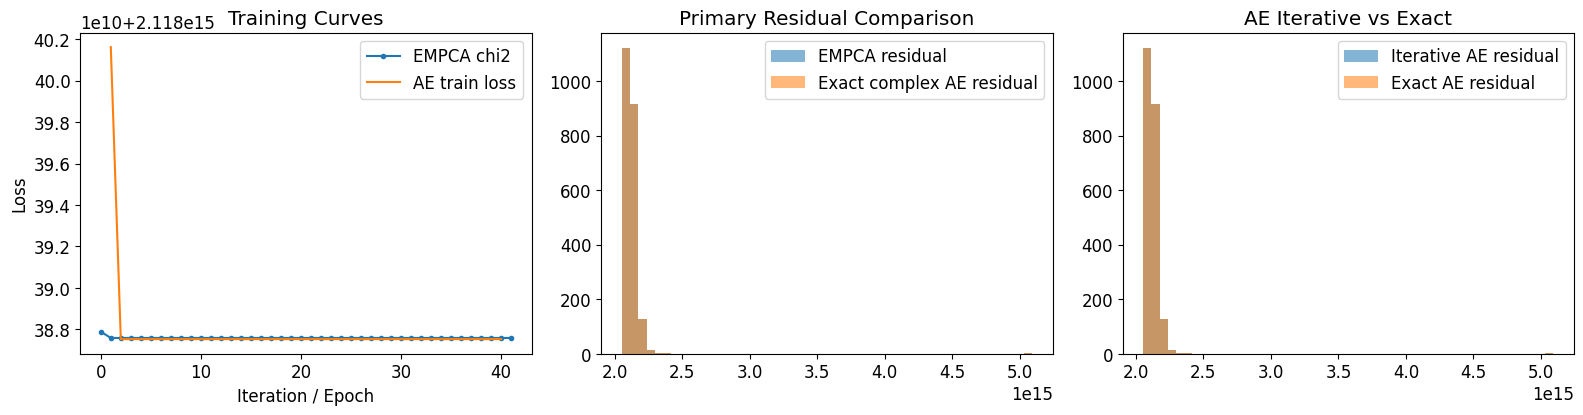

In [6]:
# 3) Primary equivalence comparison: EMPCA vs exact complex linear AE
Q_emp = orthonormalize_columns_complex(U_emp.conj().T)
Q_exact = orthonormalize_columns_complex(W_exact)

cosines = principal_angle_cosines_complex(Q_emp, Q_exact)
angles_deg = np.degrees(np.arccos(cosines))

ks_emp_exact = ks_2samp(resid_emp, resid_exact)
recon_gap_emp_exact = np.mean(np.sum(np.abs(Xhat_test_emp - Xhat_test_exact) ** 2, axis=1))

print("Principal-angle cosines (EMPCA vs exact complex AE):", np.array2string(cosines, precision=6))
print("Principal angles (deg):", np.array2string(angles_deg, precision=6))
print(f"Residual KS statistic={ks_emp_exact.statistic:.6f}, p={ks_emp_exact.pvalue:.4g}")
print(f"Mean test reconstruction gap: {recon_gap_emp_exact:.6e}")
print(f"Residual means (EMPCA, exact-AE): {resid_emp.mean():.6e}, {resid_exact.mean():.6e}")

# Effect size useful with large-N tests
rel_mean_diff = (resid_exact.mean() - resid_emp.mean()) / resid_emp.mean()
print(f"Relative mean residual difference (exact-AE vs EMPCA): {rel_mean_diff:.6e}")

fig, ax = plt.subplots(1, 3, figsize=(16, 4.5))

ax[0].plot(chi2_emp, marker='o', ms=3, label='EMPCA chi2')
ax[0].plot(np.arange(1, len(ae_losses)+1), ae_losses, label='AE train loss')
ax[0].set_title('Training Curves')
ax[0].set_xlabel('Iteration / Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].hist(resid_emp, bins=50, alpha=0.55, label='EMPCA residual')
ax[1].hist(resid_exact, bins=50, alpha=0.55, label='Exact complex AE residual')
ax[1].set_title('Primary Residual Comparison')
ax[1].legend()

ax[2].hist(resid_iter, bins=50, alpha=0.55, label='Iterative AE residual')
ax[2].hist(resid_exact, bins=50, alpha=0.55, label='Exact AE residual')
ax[2].set_title('AE Iterative vs Exact')
ax[2].legend()

plt.tight_layout()
plt.show()


## Diagnostic: Why Real-Feature AE Can Differ

If you map complex frequency vectors to real features and fit rank-`k` in real space,
that is not always equivalent to rank-`k` complex projection. This section is diagnostic only.


In [7]:
# Optional diagnostic: old-style real-feature comparison
Y_train = rfft_to_weighted_real_features(X_train_f, w_of)
Y_test = rfft_to_weighted_real_features(X_test_f, w_of)

# Real-feature top-k PCA
_, _, Vt_real = np.linalg.svd(Y_train, full_matrices=False)
Q_real_k = Vt_real[:K].T

Yhat_real_k = Y_test @ Q_real_k @ Q_real_k.T
resid_real_k = np.sum((Y_test - Yhat_real_k) ** 2, axis=1)

ks_emp_realk = ks_2samp(resid_emp, resid_real_k)
print(f"Diagnostic KS (EMPCA complex vs real-feature rank-{K}): D={ks_emp_realk.statistic:.6f}, p={ks_emp_realk.pvalue:.4g}")


Diagnostic KS (EMPCA complex vs real-feature rank-1): D=0.043598, p=0.03178


In [8]:
summary = {
    "data": {
        "n_total": int(X_all.shape[0]),
        "n_train": int(X_train_t.shape[0]),
        "n_test": int(X_test_t.shape[0]),
        "trace_len": int(X_all.shape[1]),
        "rfft_bins": int(X_train_f.shape[1]),
    },
    "model": {
        "k": int(K),
        "empca_n_iter_requested": int(N_ITER_EMPCA),
        "empca_n_iter_used": int(chi2_emp.shape[0]),
        "ae_epochs": int(AE_EPOCHS),
    },
    "primary_complex_equivalence": {
        "principal_angle_cosines": [float(v) for v in cosines],
        "principal_angles_deg": [float(v) for v in angles_deg],
        "residual_ks_statistic": float(ks_emp_exact.statistic),
        "residual_ks_pvalue": float(ks_emp_exact.pvalue),
        "mean_test_reconstruction_gap": float(recon_gap_emp_exact),
        "empca_test_resid_mean": float(np.mean(resid_emp)),
        "exact_ae_test_resid_mean": float(np.mean(resid_exact)),
        "relative_mean_residual_diff": float(rel_mean_diff),
    },
    "diagnostic_real_feature_comparison": {
        "residual_ks_statistic": float(ks_emp_realk.statistic),
        "residual_ks_pvalue": float(ks_emp_realk.pvalue),
        "real_feature_test_resid_mean": float(np.mean(resid_real_k)),
    },
}

print(json.dumps(summary, indent=2))

from pathlib import Path
out_path = Path("empca_linear_ae_summary.json")
out_path.write_text(json.dumps(summary, indent=2))
print(f"Saved summary to: {out_path.resolve()}")


{
  "data": {
    "n_total": 4358,
    "n_train": 2179,
    "n_test": 2179,
    "trace_len": 32768,
    "rfft_bins": 16385
  },
  "model": {
    "k": 1,
    "empca_n_iter_requested": 80,
    "empca_n_iter_used": 42,
    "ae_epochs": 40
  },
  "primary_complex_equivalence": {
    "principal_angle_cosines": [
      0.9999999967274091
    ],
    "principal_angles_deg": [
      0.004635360197085605
    ],
    "residual_ks_statistic": 0.0009178522257916476,
    "residual_ks_pvalue": 0.9999999999999991,
    "mean_test_reconstruction_gap": 2054441.3392232046,
    "empca_test_resid_mean": 2122094764581442.0,
    "exact_ae_test_resid_mean": 2122094754136064.0,
    "relative_mean_residual_diff": -4.922201484277365e-09
  },
  "diagnostic_real_feature_comparison": {
    "residual_ks_statistic": 0.04359798072510326,
    "residual_ks_pvalue": 0.0317765431557792,
    "real_feature_test_resid_mean": 2125809181415379.0
  }
}
Saved summary to: /home/dwong/DELight_mtr/PCA_dev/wk4/equivalence/empca_linear